In [1]:
import numpy as np

def submodular_function(S):
    # Example: A simple set coverage function
    return len(set(S))

In [2]:
class QLearningAgent:
    def __init__(self, num_actions, learning_rate=0.1, discount_factor=0.9):
        self.num_actions = num_actions
        self.q_table = np.zeros(num_actions)  # State-action values for each action
        self.alpha = learning_rate
        self.gamma = discount_factor

    def select_action(self, S, V, submodular_gain):
        # Example: selecting action based on maximum Q-value
        action_values = [submodular_gain(v, S) + self.q_table[v] for v in V]
        return np.argmax(action_values)

    def update_q_value(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table)
        target = reward + self.gamma * self.q_table[best_next_action]
        self.q_table[action] += self.alpha * (target - self.q_table[action])


In [3]:
def node_function(node_id, V_i, T, agent):
    S_i = set()
    for t in range(T):
        action = agent.select_action(S_i, V_i, lambda v, S: submodular_function(S | {v}) - submodular_function(S))
        S_i.add(action)
        reward = submodular_function(S_i)  # Reward is based on submodular gain
        agent.update_q_value(S_i, action, reward, S_i)
    return S_i


In [4]:
from concurrent.futures import ThreadPoolExecutor

def run_experiment(V, num_nodes, T):
    # Partition data among nodes
    partitions = np.array_split(V, num_nodes)
    agents = [QLearningAgent(len(V)) for _ in range(num_nodes)]

    with ThreadPoolExecutor(max_workers=num_nodes) as executor:
        futures = [executor.submit(node_function, i, partitions[i], T, agents[i]) for i in range(num_nodes)]

    local_solutions = [future.result() for future in futures]

    # Apply consensus mechanism
    global_solution = consensus(local_solutions)
    return global_solution

def consensus(local_solutions):
    # Simplified consensus: union of all subsets
    S_star = set().union(*local_solutions)
    return S_star

# Example usage
V = list(range(100))  # Example data points
num_nodes = 4
T = 10
global_solution = run_experiment(V, num_nodes, T)
print("Global solution:", global_solution)


Global solution: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [5]:
coverage_value = submodular_function(global_solution)
print("Coverage of the global solution:", coverage_value)


Coverage of the global solution: 10


AHRL-Greedy Performance Ratio: 1.0
AHRL-Greedy Performance Ratio: 1.0
AHRL-Greedy Performance Ratio: 1.0
AHRL-Greedy Performance Ratio: 1.0
AHRL-Greedy Performance Ratio: 1.0
AHRL-Greedy Performance Ratio: 1.0
AHRL-Greedy Performance Ratio: 1.0
AHRL-Greedy Performance Ratio: 1.0
AHRL-Greedy Performance Ratio: 1.0


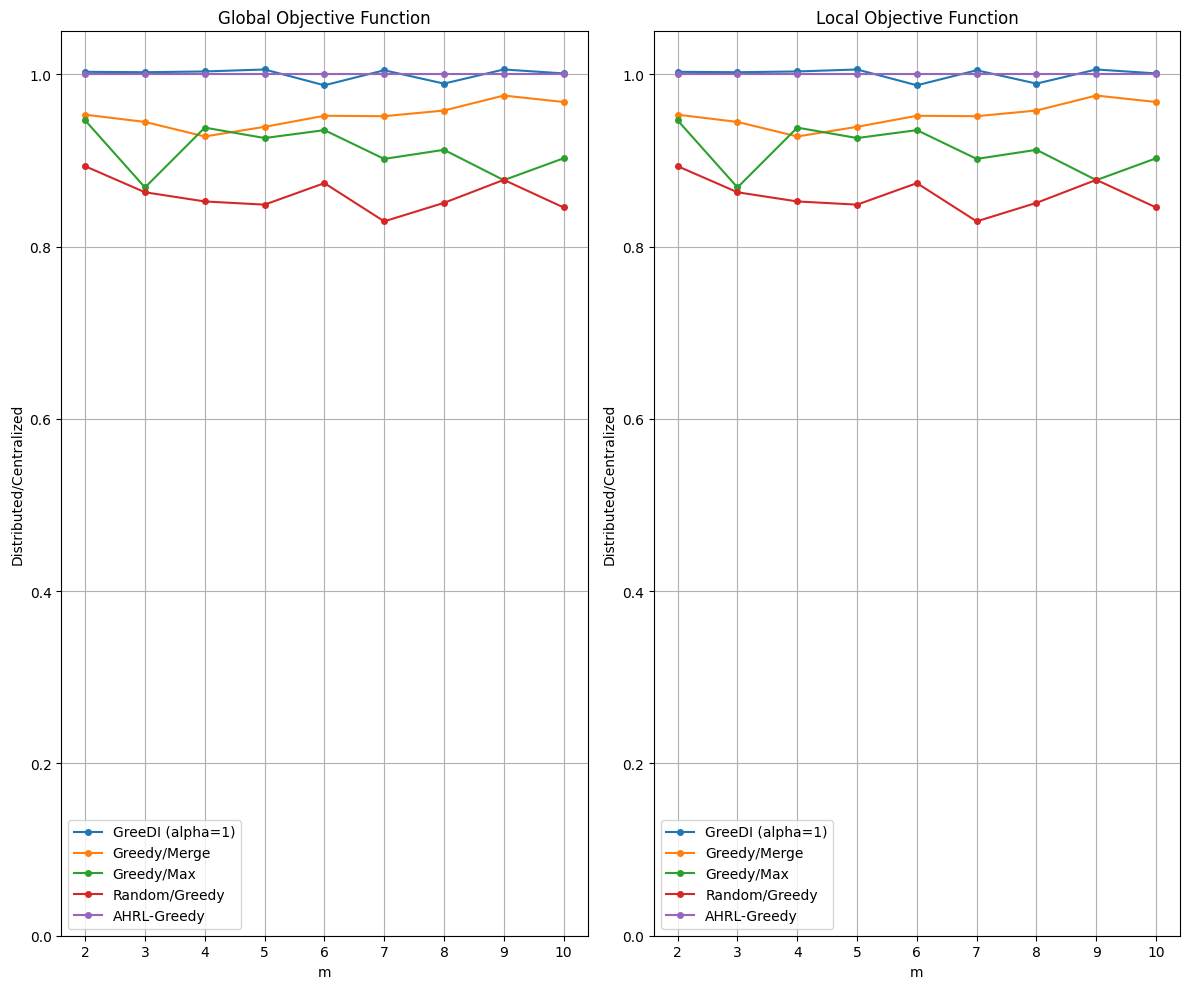

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import random

# Define the AHRL-Greedy agent class
class AHRLGreedyAgent:
    def __init__(self, num_elements, learning_rate=0.1, discount_factor=0.9, epsilon=0.9, epsilon_decay=0.99):
        self.q_table = np.zeros(num_elements)  # Q-values for each action
        self.alpha = learning_rate  # Learning rate
        self.gamma = discount_factor  # Discount factor
        self.epsilon = epsilon  # Epsilon for epsilon-greedy action selection
        self.epsilon_decay = epsilon_decay  # Epsilon decay factor

    def select_action(self, S, V, submodular_gain):
        if random.uniform(0, 1) < self.epsilon:
            # Exploration: Choose a random action
            action = random.choice(list(V))
        else:
            # Exploitation: Choose the best action based on marginal gain + Q-value
            action_values = [submodular_gain(v, S) + self.q_table[v] for v in V]
            action = list(V)[np.argmax(action_values)]
        # Decay epsilon
        self.epsilon *= self.epsilon_decay
        return action

    def update_q_value(self, action, reward):
        # Update the Q-value for the selected action using the Temporal Difference update rule
        best_next_action = np.argmax(self.q_table)
        target = reward + self.gamma * self.q_table[best_next_action]
        self.q_table[action] += self.alpha * (target - self.q_table[action])

# Function for the submodular objective
def submodular_function(S):
    # Example: A simple set coverage function
    return len(set(S))

# Node function to run AHRL-Greedy locally
def node_function(node_id, V_i, T, agent):
    S_i = set()
    for t in range(T):
        # Calculate marginal gains for all elements in V_i
        marginal_gains = {v: submodular_function(S_i | {v}) - submodular_function(S_i) for v in V_i}
        # Select element using AHRL-Greedy strategy
        action = agent.select_action(S_i, V_i, lambda v, S: marginal_gains[v])
        S_i.add(action)
        # Calculate reward
        reward = submodular_function(S_i)
        # Update Q-value
        agent.update_q_value(action, reward)
    return S_i

# Function to run the AHRL-Greedy experiment
def run_ahrl_greedy_experiment(V, num_nodes, T):
    # Partition data among nodes
    partitions = np.array_split(V, num_nodes)
    agents = [AHRLGreedyAgent(len(V)) for _ in range(num_nodes)]

    # Run node functions in parallel
    with ThreadPoolExecutor(max_workers=num_nodes) as executor:
        futures = [executor.submit(node_function, i, partitions[i], T, agents[i]) for i in range(num_nodes)]

    local_solutions = [future.result() for future in futures]

    # Apply consensus mechanism to combine the local solutions
    global_solution = consensus(local_solutions)
    return global_solution

def consensus(local_solutions):
    # Simple consensus function: take the union of all local solutions
    S_star = set().union(*local_solutions)
    return S_star

# Generating synthetic data for plotting
def generate_performance_data(x, base_value, noise_level=0.02):
    return base_value + np.random.normal(0, noise_level, len(x))

# Simulating AHRL-Greedy performance
def simulate_ahrl_greedy(x, V, num_nodes, T):
    performance = []
    for _ in x:
        global_solution = run_ahrl_greedy_experiment(V, num_nodes, T)
        performance_ratio = submodular_function(global_solution) / len(V)  # Normalized by number of elements in V
        performance.append(performance_ratio)
        # Debugging output
        print(f"AHRL-Greedy Performance Ratio: {performance_ratio}")
    return performance

# Plotting the graphs including AHRL-Greedy
V = list(range(100))  # Example data points
num_nodes = 99
T = 10

# Strategies and their respective performance data
strategies = {
    'GreeDI (alpha=1)': generate_performance_data(x1 := np.arange(2, 11, 1), 1.0, 0.01),
    'Greedy/Merge': generate_performance_data(x1, 0.95, 0.015),
    'Greedy/Max': generate_performance_data(x1, 0.9, 0.02),
    'Random/Greedy': generate_performance_data(x1, 0.85, 0.03),
    'AHRL-Greedy': simulate_ahrl_greedy(x1, V, num_nodes, T)
}

# Creating subplots similar to the provided image
fig, axs = plt.subplots(1, 2, figsize=(12, 10))

# Plotting for x1 (m) and x2 (k) values
x2 = np.arange(10, 101, 10)
for i, (ax, x, xlabel) in enumerate(zip(axs.flatten(), [x1, x1, x2, x2], ['m', 'm', 'k', 'k'])):
    for strategy, y in strategies.items():
        if len(y) == len(x):
            ax.plot(x, y, label=strategy, marker='o', linestyle='-', markersize=4)
    # Set axis labels and titles based on subplot
    if i == 0 or i == 2:
        ax.set_title('Global Objective Function')
    else:
        ax.set_title('Local Objective Function')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Distributed/Centralized')
    ax.set_ylim(0, 1.05)
    ax.grid(True)
    ax.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
